In [2]:
pip install scikit-fuzzy


In [3]:
pip install paho-mqtt

     ---------------------------------------- 0.0/99.4 kB ? eta -:--:--
     ------------------------------------- -- 92.2/99.4 kB 5.5 MB/s eta 0:00:01
     ---------------------------------------- 99.4/99.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for paho-mqtt: filename=paho_mqtt-1.6.1-py3-none-any.whl size=65647 sha256=000273bbe0024fe2aa6ed0b28432b6f3f2c54aadefc494f3ed7aa27982b42d8f
  Stored in directory: c:\users\nathan.s\appdata\local\pip\cache\wheels\29\ea\a5\ba9a63aaf4cd4e16e8a87ee31fb4d11b04ff5e1735d312619a
Successfully built paho-mqtt
Note: you may need to restart the kernel to use updated packages.


c:\Users\nathan.s\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


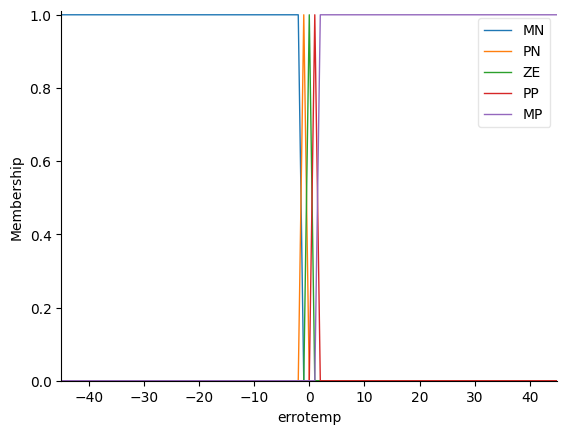

In [4]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client("c213Inatelsbm")
client.connect(mqttBroker)

errotemp = ctrl.Antecedent(np.arange(-45, 46, 1), 'errotemp')
varerrotemp = ctrl.Antecedent(np.arange(-2, 2.01, 0.01), 'varerrotemp')
# aquecedor =ctrl.Consequent(np.arange(0, 100, 1), 'aquecedor')
resfriador = ctrl.Consequent(np.arange(0, 101, 1), 'resfriador')

errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-45, -45, -2,-1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2,-1,0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[1, 2, 45,45])
errotemp.view()

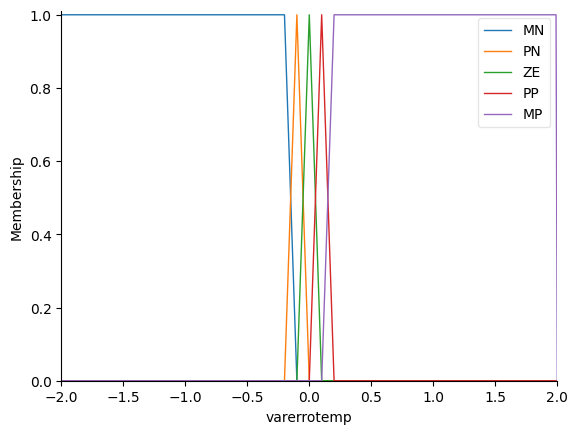

In [5]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 2,2])
varerrotemp.view()

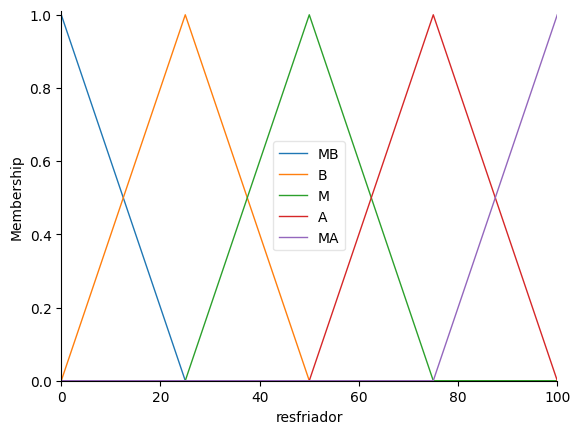

In [11]:
# Considerações
# Muito Baixo-> 0 a 25
# Baixo -> 25 a  50 
# Medio -> 25 a 75
# Alta -> 50 a 100
# Muito alta -> 75 a 100

resfriador['MB'] = fuzz.trimf(resfriador.universe, [0,0,25])
resfriador['B'] = fuzz.trimf(resfriador.universe, [0,25,50])
resfriador['M'] = fuzz.trimf(resfriador.universe, [25, 50, 75])
resfriador['A'] = fuzz.trimf(resfriador.universe, [50, 75, 100])
resfriador['MA'] = fuzz.trimf(resfriador.universe, [75, 100, 100])
resfriador.view()

In [ ]:
# REGRAS RETIRADAS PELA TABELA

regra1 = ctrl.Rule(errotemp['MN']& varerrotemp['MN'], resfriador['MB'])
regra2 = ctrl.Rule(errotemp['PN']& varerrotemp['MN'], resfriador['MB'])
regra3 = ctrl.Rule(errotemp['ZE']& varerrotemp['MN'], resfriador['M'])
regra4 = ctrl.Rule(errotemp['PP']& varerrotemp['MN'], resfriador['A'])
regra5 = ctrl.Rule(errotemp['MP']& varerrotemp['MN'], resfriador['A'])
regra6 = ctrl.Rule(errotemp['MN']& varerrotemp['PN'], resfriador['MB'])
regra7 = ctrl.Rule(errotemp['PN']& varerrotemp['PN'], resfriador['M'])
regra8 = ctrl.Rule(errotemp['ZE']& varerrotemp['PN'], resfriador['M'])
regra9 = ctrl.Rule(errotemp['PP']& varerrotemp['PN'], resfriador['M'])
regra10 = ctrl.Rule(errotemp['MP']& varerrotemp['PN'], resfriador['A'])
regra11 = ctrl.Rule(errotemp['MN']& varerrotemp['ZE'], resfriador['M'])
regra12 = ctrl.Rule(errotemp['PN']& varerrotemp['ZE'], resfriador['M'])
regra13 = ctrl.Rule(errotemp['ZE']& varerrotemp['ZE'], resfriador['M'])
regra14 = ctrl.Rule(errotemp['PP']& varerrotemp['ZE'], resfriador['M'])
regra15 = ctrl.Rule(errotemp['MP']& varerrotemp['ZE'], resfriador['M'])
regra16 = ctrl.Rule(errotemp['MN']& varerrotemp['PP'], resfriador['B'])
regra17 = ctrl.Rule(errotemp['PN']& varerrotemp['PP'], resfriador['M'])
regra18 = ctrl.Rule(errotemp['ZE']& varerrotemp['PP'], resfriador['M'])
regra19 = ctrl.Rule(errotemp['PP']& varerrotemp['PP'], resfriador['M'])
regra20 = ctrl.Rule(errotemp['MP']& varerrotemp['PP'], resfriador['MA'])
regra21 = ctrl.Rule(errotemp['MN']& varerrotemp['MP'], resfriador['B'])
regra22 = ctrl.Rule(errotemp['PN']& varerrotemp['MP'], resfriador['B'])
regra23 = ctrl.Rule(errotemp['ZE']& varerrotemp['MP'], resfriador['M'])
regra24 = ctrl.Rule(errotemp['PP']& varerrotemp['MP'], resfriador['MA'])
regra25 = ctrl.Rule(errotemp['MP']& varerrotemp['MP'], resfriador['MA'])

In [ ]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [ ]:
sp=30
tempatual=32
print(tempatual)
erroatual=0
while True: 
  erroanterior=erroatual
  erroatual=tempatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['errotemp'] =erroatual
  potencia.input['varerrotemp'] =varerroTemp
  potencia.compute()
  i=0
  while (i < 10):
    tempatual=tempatual * 0.9954 + potencia.output['aquecedor'] * 0.002763
    time.sleep(1)
    i += 1
  print(tempatual)
  client.publish("Aquecedor/Temperatura", tempatual)
  client.publish("Aquecedor/erro", erroatual)

32
31.911350554209825
31.826695598088033
31.74585514237957
31.6686573080348
31.594937960768704
31.524540362086483
31.45731483603382
31.3931184509631
31.33181471563912
31.273273289038023
31.21736970322258
31.16398509870449
31.1130059717311
31.06432393295927
31.01783547700317
30.973441762366228
30.931048401289058
30.890565259066868
30.85190626240937
30.814989216435965
30.77973562991698
30.746070548389415
30.713922394792398
30.68322281728355
30.65390654391259
30.625911243843294
30.599177394828697
30.573648156657782
30.549269250304587
30.52598884252277
30.503757435640306
30.4825277623199
30.4622546850615
30.44289510023312
30.424407846426018
30.40675361693927
30.389894876207805
30.373795779996097
30.358422099187894
30.343741147009922
30.329721709534887
30.316333979315907
30.303549492011374
30.291341065865478
30.279682743915632
30.268549738804083
30.25791838007622
30.247766063853597
30.23807120477467
30.228813190101054
30.219972335891715
30.211529845151922
30.20346776786802
30.19576896284295